# VISUAL QUESTION ANSWERING : (IMPLEMENTATION IN TENSORFLOW 2.0)



In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **PART: 1 Question to Embedding :**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
! ls

drive  sample_data


In [ ]:
model_path = '/content/drive/MyDrive/Copy of GoogleNews-vectors-negative300.bin.gz'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)            # Loading the model using gensim

In [ ]:




def extract_feat(doc):
  '''
    Input: A sentence
    Output : Word Embedding of the sentence

    Note : In order to maintain uniformity in the word embedding of the question, I have used padding (which would be shown later) with a maximum length of 21 (since this
    is the longest length of the question in trainset.json)
  '''
  feat = []
  for word in doc:
      try:
          feat.append(model_w2v[word])
      except:
          pass
  return feat

def tokenize(sentence):

    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    '''
    Input: The question from trainset.json
    Performs tokenization and lowering of the question
    Output: Embedded version of the question

    Note that: We have still not padded the questions, just for information each of the word will be a 300 Dimensional Vector,
    hence, the word vector (which will be obtained after padding) will be a (21,300) Dimensional
    '''
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()
    return imgs

def get_top_answers(imgs, num_ans):

    """
    Print the questions and returns the time, one answer is repeated
    """
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  # If the string is a number, it would result into error
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:')
    print('\n'.join(map(str,cw[:20])))

    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):

  ''' Not of much use, I had used it for some other purpose, but did not use it later '''
  new_imgs = []
  for i, img in enumerate(imgs):
          new_imgs.append(img)

  print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
  return new_imgs

manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }

imgs_train = json.load(open('/content/drive/MyDrive/trainset.json' , 'r'))      # Unnnecesarily, i have used the same file two times
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans)
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
imgs_data_train = json.load(open('/content/drive/MyDrive/trainset.json' , 'r'))  # trainset.json
num_ans = 10    # Even 1 should work fine, but I had taken reference from COCO dataset, and hence, 10 (10 represents the top 10 answers to a picture)
method = 'nltk'
max_length = 21                       # Max Length of the question
dir_path = "/content/drive/MyDrive/QA"    # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/drive/MyDrive/VQA_RAD Image Folder'

def save_data():


        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.close()
        return

data = save_data()

top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')
0 Are regions of the brain infarcted?
1 Are the lungs normal appearing?
2 Is there evidence of a pneumothorax
3 What type of imaging does this not represent?
4 Is this a MRI of the chest?
5 What is not pictured in this image?
6 Is the trachea midline?
7 Is there evidence of an aortic aneurysm?
8 Where is the abnormality?
9 Is there blunting of the costovertebral angles?
10 Which organ system is abnormal in this image?
11 Where is the pathology in this image?
12 Is there a pneumothorax?
13 What type of imaging is this?
14 What organ system is pictured?
15 Is there a fracture?
16 Is there swelling of the grey matter?
17 Is 

<a id="t1."></a>
# **PART: 2 Loading and Preparaing the dataset for the Model:**


In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import os
import matplotlib.pyplot as plt
dropout_rate = 0.4
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------------------------------------
# The below part is same as that of part 1

def extract_feat(doc):
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

def tokenize(sentence):
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):

    # preprocess all the question
    print('example processed tokens:')
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()
    return imgs

def get_top_answers(imgs, num_ans):
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1 # Frequency count

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    # print('top answer and their counts:')
    # print('\n'.join(map(str,cw[:20])))

    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):
    new_imgs = []
    for i, img in enumerate(imgs):
            new_imgs.append(img)

    print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
    return new_imgs
# Old Part finishes
# ---------------------------------------------------------------------------------------------------------------------
# New part starts
# -------------------------------------------------------------------------------------------------------------------
def image_layer(input_shape):
    '''
    Input : Shape of the image
    Output : VGG16 Preprocessing model
    '''
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False # Do not train it
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            # This step can be found out in the slides, that after feature extraction, they are connecting a dense layer, slide - 6 (Transform into a same size vector)
    return x

def vgg_preprocessing(model,image):
  ''' Takes a tensor as an input, and returns a pre processed version of the image'''
  return model(image)

def load_data():

        '''
        Input: Nothing

        Output: Returns list containing the following four elements in a tuple
        (preprocessed version of the image,embedded question,embedded answer, question id)
        '''

        images = []
        questions = []
        answers = []
        ids = []

        #print(start,end)
        #arrs = np.random.randint(0,len(imgs_data_train),batch)
        #data = [imgs_data_train[i] for i in arrs]

        data = imgs_data_train   # trainset.json
        model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
        for i,img in enumerate(data):

            img_path = img['image_name']  # Image Name
            question_id = img['qid']      # Question id

            #label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32') # Somethings are taken directly from

            with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as hf:

                question = hf['.']['ques_train'][()] # Embedded question
                answer = hf['.']['answers'][()]      # Embedded answer

            image = cv2.imread(os.path.join('/content/drive/MyDrive/VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (448,448)) # Reshape

            '''
            Small Note : I had not applied the VGG Preprocessing here, because I wanted to use the original shape of 448, and then, I would
            attach the VGG Model, while making the model, I think this makes sense :)
            '''
            #image = vgg_preprocessing(model,image)
            # Apply VGG16 Preprocessings

            images.append(image)
            questions.append(np.array(question))
            answers.append(np.array(answer))
            ids.append(question_id)
            if i%100==0:
              print("Processed =>",i,' which is',round(100*i/len(data),2),'%')

        questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
        return (np.array(images) , questions ,np.array(answers) , np.array(ids))

imgs_train = json.load(open('/content/drive/MyDrive/trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('/content/drive/MyDrive/trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "/content/drive/MyDrive/QA"
N = len(imgs_data_train)

# ---------------------------------------------------------------------------------------
# New part finishes

In [ ]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

''' These parameters are for some of the previous attempts, so ignore it, the main part is : datagen = load_data(), and I don't want to remove all of these,
because indeed there can be some ideas coming out from these lines of code'''

embed_size = 300
q_len = 21
height = 224
width = 224
lstm_units = 256
attention_dim = 512
num_output = 1000
max_questions = 3064

batch_size = 32
lr = 0.001
articles = ['a', 'an', 'the']
manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }


datagen = load_data()   # Load the Data

58889256/58889256 [==============================] - 2s 0us/step
Processed => 0  which is 0.0 %
Processed => 100  which is 3.26 %
Processed => 200  which is 6.53 %
Processed => 300  which is 9.79 %
Processed => 400  which is 13.05 %
Processed => 500  which is 16.32 %
Processed => 600  which is 19.58 %
Processed => 700  which is 22.85 %
Processed => 800  which is 26.11 %
Processed => 900  which is 29.37 %
Processed => 1000  which is 32.64 %
Processed => 1100  which is 35.9 %
Processed => 1200  which is 39.16 %
Processed => 1300  which is 42.43 %
Processed => 1400  which is 45.69 %
Processed => 1500  which is 48.96 %
Processed => 1600  which is 52.22 %
Processed => 1700  which is 55.48 %
Processed => 1800  which is 58.75 %
Processed => 1900  which is 62.01 %
Processed => 2000  which is 65.27 %
Processed => 2100  which is 68.54 %
Processed => 2200  which is 71.8 %
Processed => 2300  which is 75.07 %
Processed => 2400  which is 78.33 %
Processed => 2500  which is 81.59 %
Processed => 2600 

### Creating the Dataset: We do this, by renaming the contents of .h5 file

In [ ]:
images,questions,answers,ids =datagen[0],datagen[1],datagen[2],datagen[3]
print("Images have a size of:",images.shape)
print("Questions have a size of:",questions.shape)
print("Answers have a size of:",answers.shape)
print("Ids have a size of:",ids.shape)
dir_path = r'/content/drive/MyDrive/QA' # The directory where the .h5 file for each entry is saved
m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding (Not preprocessed)
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form
    f.close()
    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/images.shape[0],2),' %')
print("Your processing has been done")

Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)
Processed => 0  total percentage => 0.0  %
Processed => 100  total percentage => 3.26  %
Processed => 200  total percentage => 6.53  %
Processed => 300  total percentage => 9.79  %
Processed => 400  total percentage => 13.05  %
Processed => 500  total percentage => 16.32  %
Processed => 600  total percentage => 19.58  %
Processed => 700  total percentage => 22.85  %
Processed => 800  total percentage => 26.11  %
Processed => 900  total percentage => 29.37  %
Processed => 1000  total percentage => 32.64  %
Processed => 1100  total percentage => 35.9  %
Processed => 1200  total percentage => 39.16  %
Processed => 1300  total percentage => 42.43  %
Processed => 1400  total percentage => 45.69  %
Processed => 1500  total percentage => 48.96  %
Processed => 1600  total percentage => 52.22  %
Processed => 1700  total percentage => 55.48  %
Processed

<a id="t2."></a>
# **PART: 3 Making the Model**  

In [ ]:
# link - http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf
import os,h5py
# Image Model
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
#print("The Last layer")
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = model(image)
    return image  # Shape is (196,512)

'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''

dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

train_dir = r'drive/MyDrive/QA/' # Containing .h5 file
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:2300]   # The GPU Memory became full after this, hence had to take just these much samples :(
length = len(content)
for i in content:
    # Reading the data
    file = h5py.File(train_dir+i)
    images.append(np.array(file['.']['image_vector'][()]))
    ans.append(np.array(file['.']['answers'][()]))
    ques.append(np.array(file['.']['ques_train'][()]))
    count+=1
    if count%100 == 0:
      print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')
images = tf.convert_to_tensor(np.array(images))   # For the GPU purpose
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))

In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))  # It was not possible directly on GPU, hence had to use for loop
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [ ]:
images = tf.reshape(images,[length,21,300])
img = images  #Tensor containing images
que = ques  # Tensor containing question vector
img = img/255.0 # Normalizing

In [ ]:
que.shape,img.shape

(TensorShape([2300, 21, 300]), TensorShape([2300, 21, 300]))

In [ ]:
''' The below mentioned two Input objects of keras will be useful for making the model '''

ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate, Multiply, Permute, Reshape

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(imagica)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

attention = Dense(512, activation='softmax')(quesa)
attention = Reshape((512, 21))(attention)
attention = Permute((2, 1))(attention)
attention_applied = Multiply()([imagica, attention])

''' Concatenating both image and the question layer'''
combined = Concatenate()([attention_applied, quesa])
combined = Flatten()(combined)

out = tf.keras.layers.Dense(476,activation='softmax')(combined) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate, Multiply, Permute, Reshape

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
# imagica = Dense(512,activation='tanh')(imagica)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

attention = Dense(512, activation='softmax')(quesa)
attention = Reshape((512, 21))(attention)
attention = Permute((2, 1))(attention)
attention_applied = Multiply()([imagica, attention])

''' Concatenating both image and the question layer'''
combined = Concatenate()([attention_applied, quesa])
combined = Flatten()(combined)

out = tf.keras.layers.Dense(476,activation='softmax')(combined) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate, Multiply, Permute, Reshape, Bidirectional

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(imagica)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = Bidirectional(LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300)))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

attention = Dense(512, activation='softmax')(quesa)
attention = Reshape((512, 21))(attention)
attention = Permute((2, 1))(attention)
attention_applied = Multiply()([imagica, attention])

''' Concatenating both image and the question layer'''
combined = Concatenate()([attention_applied, quesa])
combined = Flatten()(combined)

out = tf.keras.layers.Dense(476,activation='softmax')(combined) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate, Multiply, Permute, Reshape, Bidirectional

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(imagica)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = Bidirectional(LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300)))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

attention_1 = Dense(512, activation='softmax')(quesa)
attention_1 = Reshape((512, 21))(attention_1)
attention_1 = Permute((2, 1))(attention_1)
attention_1_applied = Multiply()([imagica, attention_1])

attention_2 = Dense(512, activation='softmax')(attention_1_applied)
attention_2 = Reshape((512, 21))(attention_2)
attention_2 = Permute((2, 1))(attention_2)
attention_2_applied = Multiply()([imagica, attention_2])

''' Concatenating both image and the question layer'''
combined = Concatenate()([attention_2_applied, quesa])
combined = Flatten()(combined)

out = tf.keras.layers.Dense(476,activation='softmax')(combined) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate, Multiply, Permute, Reshape, Bidirectional

''' Imagica is for the preprocessing of the image part'''
imagica1 = Dense(512,activation='tanh')(images)
imagica2 = Dense(512,activation='tanh')(imagica1)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa1 = Bidirectional(LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300)))(ques)
quesa2 = Dense(512, activation = 'relu')(quesa1)
quesa3 = Dropout(0.3)(quesa2)
quesa4 = Dense(512, activation = 'relu')(quesa3)
quesa5 = Dropout(0.3)(quesa4)

attention_1 = Dense(512, activation='softmax')(quesa5)
attention_1_reshaped = Reshape((512, 21))(attention_1)
attention_1_permuted = Permute((2, 1))(attention_1_reshaped)
attention_1_applied = Multiply()([imagica2, attention_1_permuted])

attention_2 = Dense(512, activation='softmax')(attention_1_applied)
attention_2_reshaped = Reshape((512, 21))(attention_2)
attention_2_permuted = Permute((2, 1))(attention_2_reshaped)
attention_2_applied = Multiply()([imagica2, attention_2_permuted])

''' Concatenating both image and the question layer'''
combined = Concatenate()([attention_2_applied, quesa5])
combined_flat = Flatten()(combined)

out = tf.keras.layers.Dense(476,activation='softmax')(combined_flat) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

In [ ]:
imagica_1 = Dense(512, activation='tanh', name='imagica_1')(images)
imagica_2 = Dense(512, activation='tanh', name='imagica_2')(imagica_1)

quesa_1 = Bidirectional(LSTM(512, dropout=0.3, return_sequences=True, name='quesa_lstm'), input_shape=(21,300))(ques)
quesa_2 = Dense(512, activation='relu', name='quesa_dense_1')(quesa_1)
quesa_3 = Dropout(0.3, name='quesa_dropout_1')(quesa_2)
quesa_4 = Dense(512, activation='relu', name='quesa_dense_2')(quesa_3)
quesa_5 = Dropout(0.3, name='quesa_dropout_2')(quesa_4)

attention_1 = Dense(512, activation='softmax', name='attention_1')(quesa_5)
attention_1_reshaped = Reshape((512, 21), name='attention_1_reshape')(attention_1)
attention_1_permuted = Permute((2, 1), name='attention_1_permute')(attention_1_reshaped)
attention_1_applied = Multiply(name='attention_1_multiply')([imagica_2, attention_1_permuted])

attention_2 = Dense(512, activation='softmax', name='attention_2')(attention_1_applied)
attention_2_reshaped = Reshape((512, 21), name='attention_2_reshape')(attention_2)
attention_2_permuted = Permute((2, 1), name='attention_2_permute')(attention_2_reshaped)
attention_2_applied = Multiply(name='attention_2_multiply')([imagica_2, attention_2_permuted])

combined = Concatenate(name='concatenate')([attention_2_applied, quesa_5])
combined_flatten = Flatten(name='flatten')(combined)

out = Dense(476, activation='softmax', name='output')(combined_flatten)

In [ ]:
ques.shape

TensorShape([None, 21, 300])

In [ ]:
from sklearn.model_selection import train_test_split

# Convert tensors to numpy arrays if they are not already
img_np = img.numpy() if isinstance(img, tf.Tensor) else img
que_np = que.numpy() if isinstance(que, tf.Tensor) else que
ans_np = ans.numpy() if isinstance(ans, tf.Tensor) else ans

# Now, use the numpy arrays with train_test_split
img_train, img_val, que_train, que_val, ans_train, ans_val = train_test_split(
    img_np, que_np, ans_np, test_size=0.1, random_state=42
)

# Make sure to convert your numpy arrays back to tensors if your model expects tensors
img_train, img_val, que_train, que_val, ans_train, ans_val = map(
    tf.convert_to_tensor,
    (img_train, img_val, que_train, que_val, ans_train, ans_val)
)

model = Model([ques, images], [out])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now, use the training and validation data in model.fit
history = model.fit(
    [img_train, que_train], ans_train,
    validation_data=([img_val, que_val], ans_val),
    epochs=50, batch_size=32, verbose=1
)


Epoch 1/50
65/65 [==============================] - 8s 36ms/step - loss: 4.2005 - accuracy: 0.2831 - val_loss: 3.7738 - val_accuracy: 0.2870
Epoch 2/50
65/65 [==============================] - 1s 19ms/step - loss: 3.5808 - accuracy: 0.3188 - val_loss: 3.5686 - val_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 1s 19ms/step - loss: 3.0594 - accuracy: 0.3517 - val_loss: 3.0291 - val_accuracy: 0.3478
Epoch 4/50
65/65 [==============================] - 1s 19ms/step - loss: 2.1910 - accuracy: 0.4203 - val_loss: 2.4795 - val_accuracy: 0.4348
Epoch 5/50
65/65 [==============================] - 1s 19ms/step - loss: 1.5603 - accuracy: 0.5097 - val_loss: 2.2321 - val_accuracy: 0.4304
Epoch 6/50
65/65 [==============================] - 1s 19ms/step - loss: 1.3035 - accuracy: 0.5430 - val_loss: 2.0278 - val_accuracy: 0.4565
Epoch 7/50
65/65 [==============================] - 1s 19ms/step - loss: 1.1092 - accuracy: 0.6039 - val_loss: 2.0170 - val_accuracy: 0.4870
Epoch 8/50
65

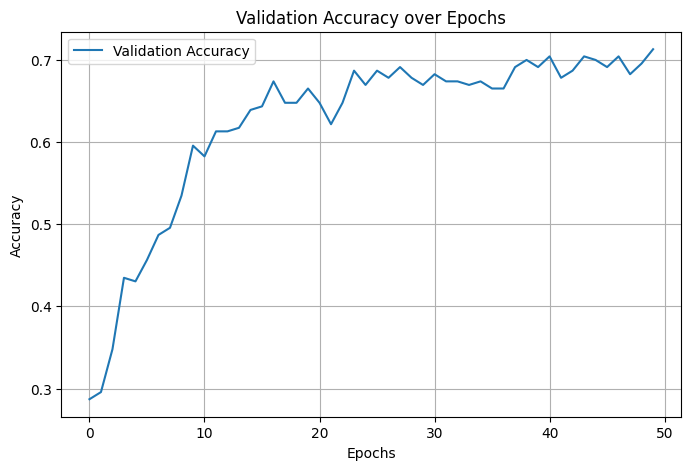

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the 'fit' function
# which contains the training history metrics

# Plot the validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


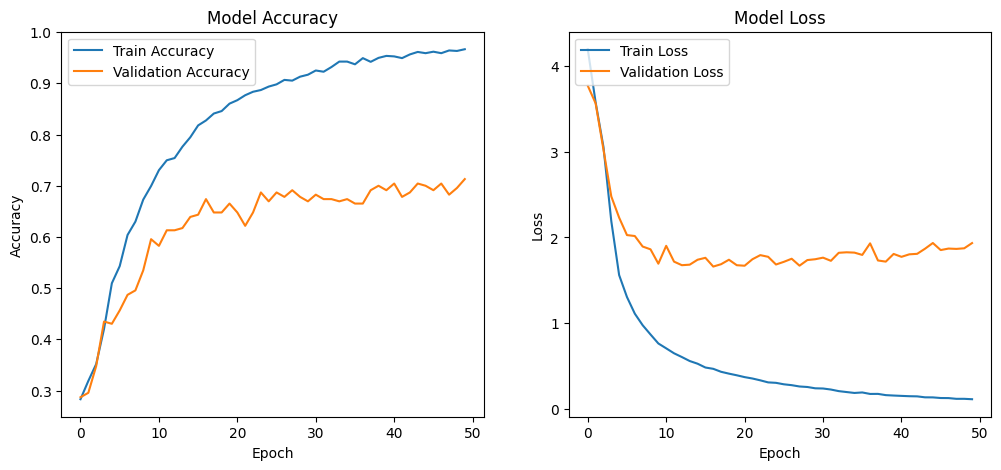

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


plt.show()


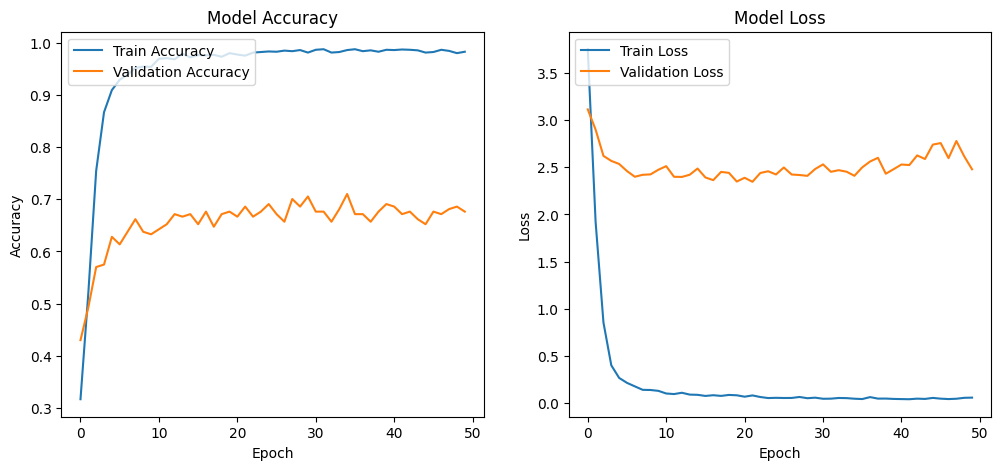

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Convert tensors to numpy arrays if they are not already
img_np = img.numpy() if isinstance(img, tf.Tensor) else img
que_np = que.numpy() if isinstance(que, tf.Tensor) else que
ans_np = ans.numpy() if isinstance(ans, tf.Tensor) else ans

# First, split the data into a combined training/validation set and a separate test set
img_temp, img_test, que_temp, que_test, ans_temp, ans_test = train_test_split(
    img_np, que_np, ans_np, test_size=0.1, random_state=42
)

# Then, split the temporary training/validation set into separate training and validation sets
img_train, img_val, que_train, que_val, ans_train, ans_val = train_test_split(
    img_temp, que_temp, ans_temp, test_size=0.1, random_state=42  # This will actually be 9% of the original data
)

# Make sure to convert your numpy arrays back to tensors if your model expects tensors
img_train, img_val, img_test = map(tf.convert_to_tensor, (img_train, img_val, img_test))
que_train, que_val, que_test = map(tf.convert_to_tensor, (que_train, que_val, que_test))
ans_train, ans_val, ans_test = map(tf.convert_to_tensor, (ans_train, ans_val, ans_test))

model = Model([ques, images], [out])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now, use the training and validation data in model.fit
history = model.fit(
    [img_train, que_train], ans_train,
    validation_data=([img_val, que_val], ans_val),
    epochs=50, batch_size=32, verbose=1
)

Epoch 1/50
59/59 [==============================] - 7s 36ms/step - loss: 4.5092 - accuracy: 0.2802 - val_loss: 3.7990 - val_accuracy: 0.3671
Epoch 2/50
59/59 [==============================] - 1s 19ms/step - loss: 3.6087 - accuracy: 0.3253 - val_loss: 3.6205 - val_accuracy: 0.3623
Epoch 3/50
59/59 [==============================] - 1s 19ms/step - loss: 3.0632 - accuracy: 0.3360 - val_loss: 3.2026 - val_accuracy: 0.4203
Epoch 4/50
59/59 [==============================] - 1s 19ms/step - loss: 2.3061 - accuracy: 0.3875 - val_loss: 2.8348 - val_accuracy: 0.5072
Epoch 5/50
59/59 [==============================] - 1s 19ms/step - loss: 1.6857 - accuracy: 0.4767 - val_loss: 2.4685 - val_accuracy: 0.4976
Epoch 6/50
59/59 [==============================] - 1s 19ms/step - loss: 1.3959 - accuracy: 0.5153 - val_loss: 2.5213 - val_accuracy: 0.5556
Epoch 7/50
59/59 [==============================] - 1s 19ms/step - loss: 1.1889 - accuracy: 0.5582 - val_loss: 2.2686 - val_accuracy: 0.5507
Epoch 8/50
59

In [ ]:
model = Model([ques, images], [out])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now, use the training and validation data in model.fit
history = model.fit(
    [img_train, que_train], ans_train,
    validation_data=([img_val, que_val], ans_val),
    epochs=50, batch_size=32, verbose=1
)

Epoch 1/50
59/59 [==============================] - 4s 22ms/step - loss: 3.7478 - accuracy: 0.3167 - val_loss: 3.1111 - val_accuracy: 0.4300
Epoch 2/50
59/59 [==============================] - 1s 12ms/step - loss: 1.9192 - accuracy: 0.5207 - val_loss: 2.8972 - val_accuracy: 0.4928
Epoch 3/50
59/59 [==============================] - 1s 12ms/step - loss: 0.8563 - accuracy: 0.7547 - val_loss: 2.6189 - val_accuracy: 0.5700
Epoch 4/50
59/59 [==============================] - 1s 12ms/step - loss: 0.4029 - accuracy: 0.8669 - val_loss: 2.5659 - val_accuracy: 0.5749
Epoch 5/50
59/59 [==============================] - 1s 12ms/step - loss: 0.2697 - accuracy: 0.9093 - val_loss: 2.5336 - val_accuracy: 0.6280
Epoch 6/50
59/59 [==============================] - 1s 12ms/step - loss: 0.2172 - accuracy: 0.9291 - val_loss: 2.4586 - val_accuracy: 0.6135
Epoch 7/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1802 - accuracy: 0.9388 - val_loss: 2.3982 - val_accuracy: 0.6377
Epoch 8/50
59

In [ ]:
test_loss, test_accuracy = model.evaluate([img_test, que_test], ans_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 0s 7ms/step - loss: 1.9883 - accuracy: 0.6783
Test Loss: 1.988277554512024
Test Accuracy: 0.678260862827301


In [ ]:
test_loss, test_accuracy = model.evaluate([img_test, que_test], ans_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 0s 7ms/step - loss: 2.0095 - accuracy: 0.7087
Test Loss: 2.0094778537750244
Test Accuracy: 0.708695650100708


## Random Experiments Ahead

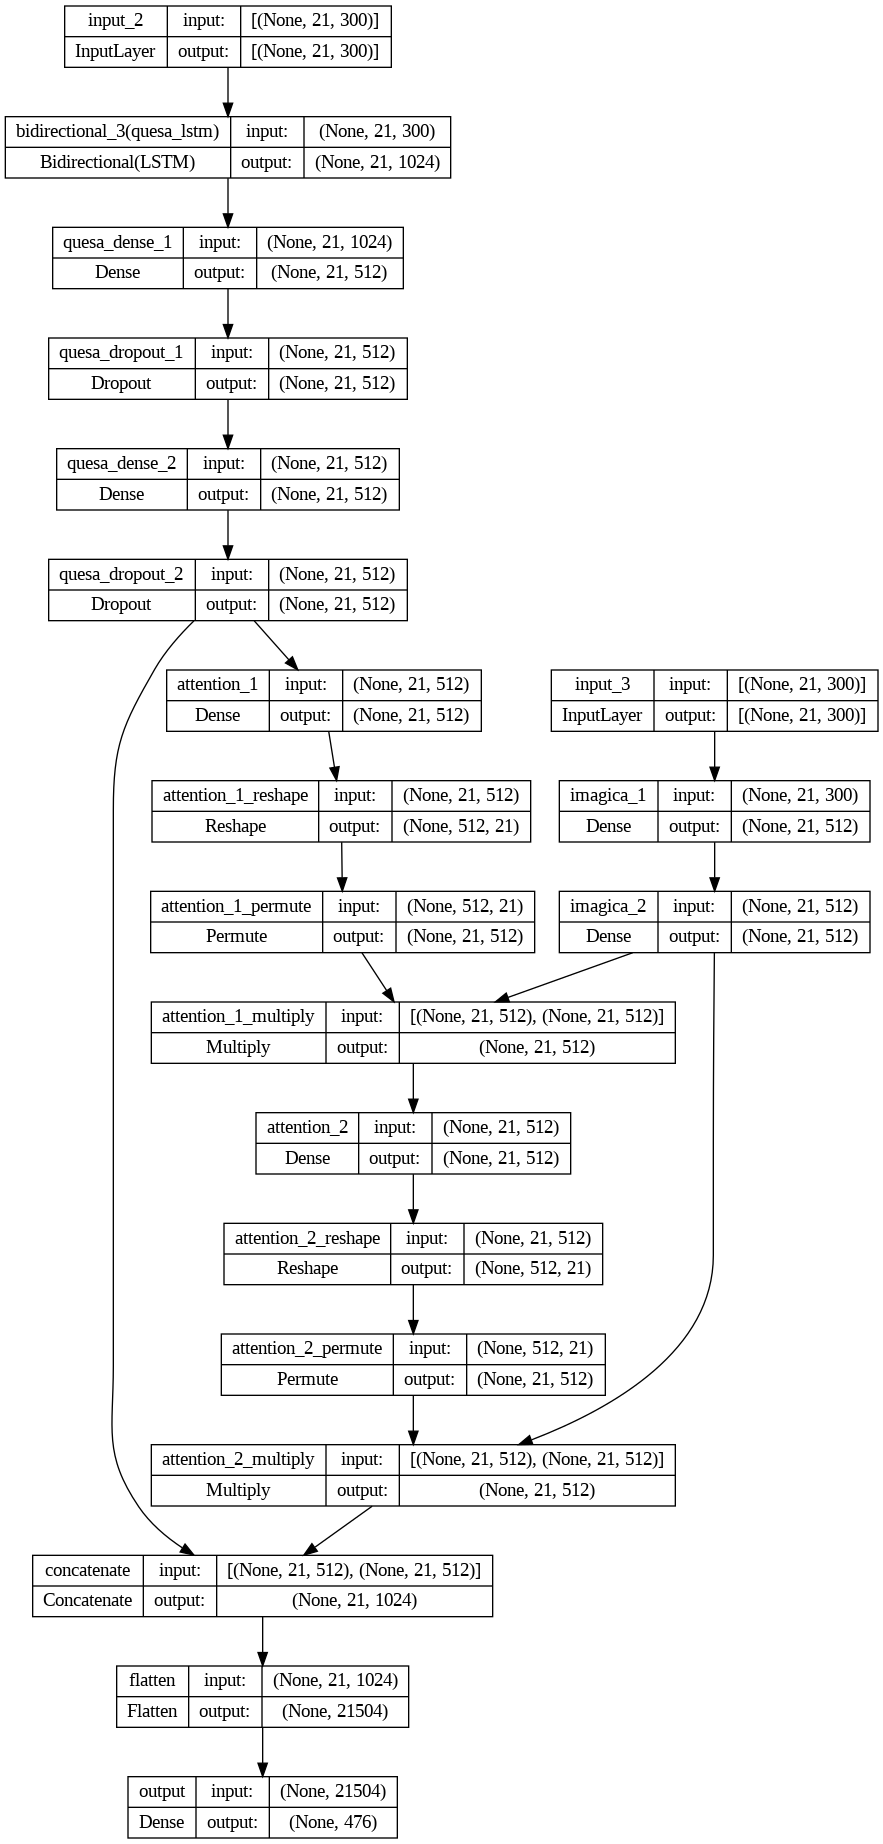

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out, attention_1, attention_2])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

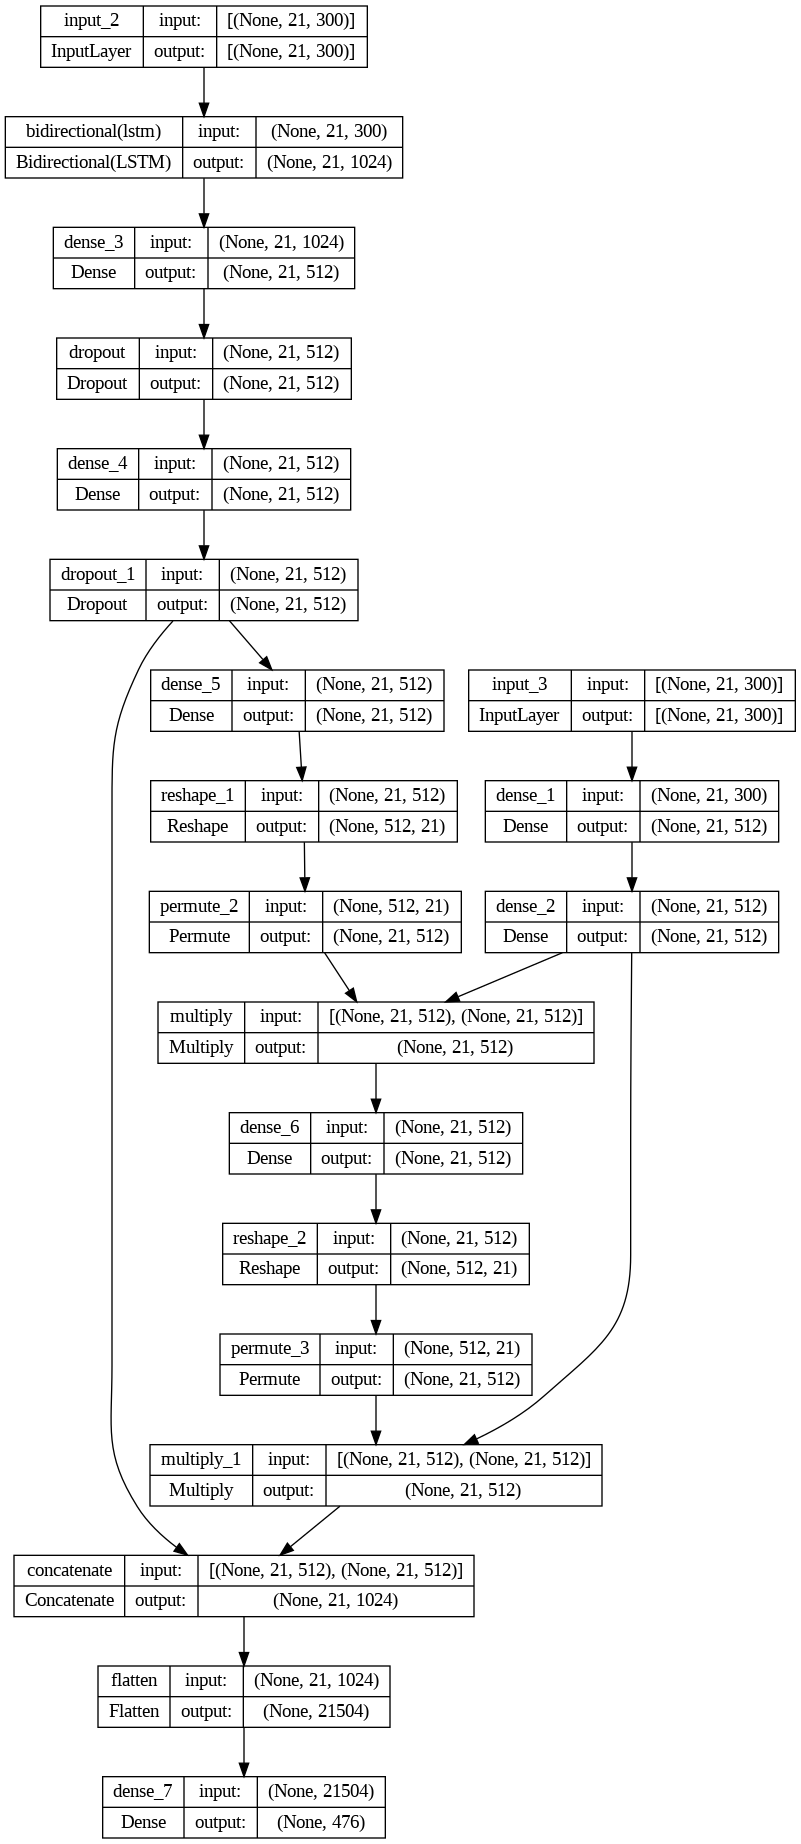

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out, attention_1, attention_2])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

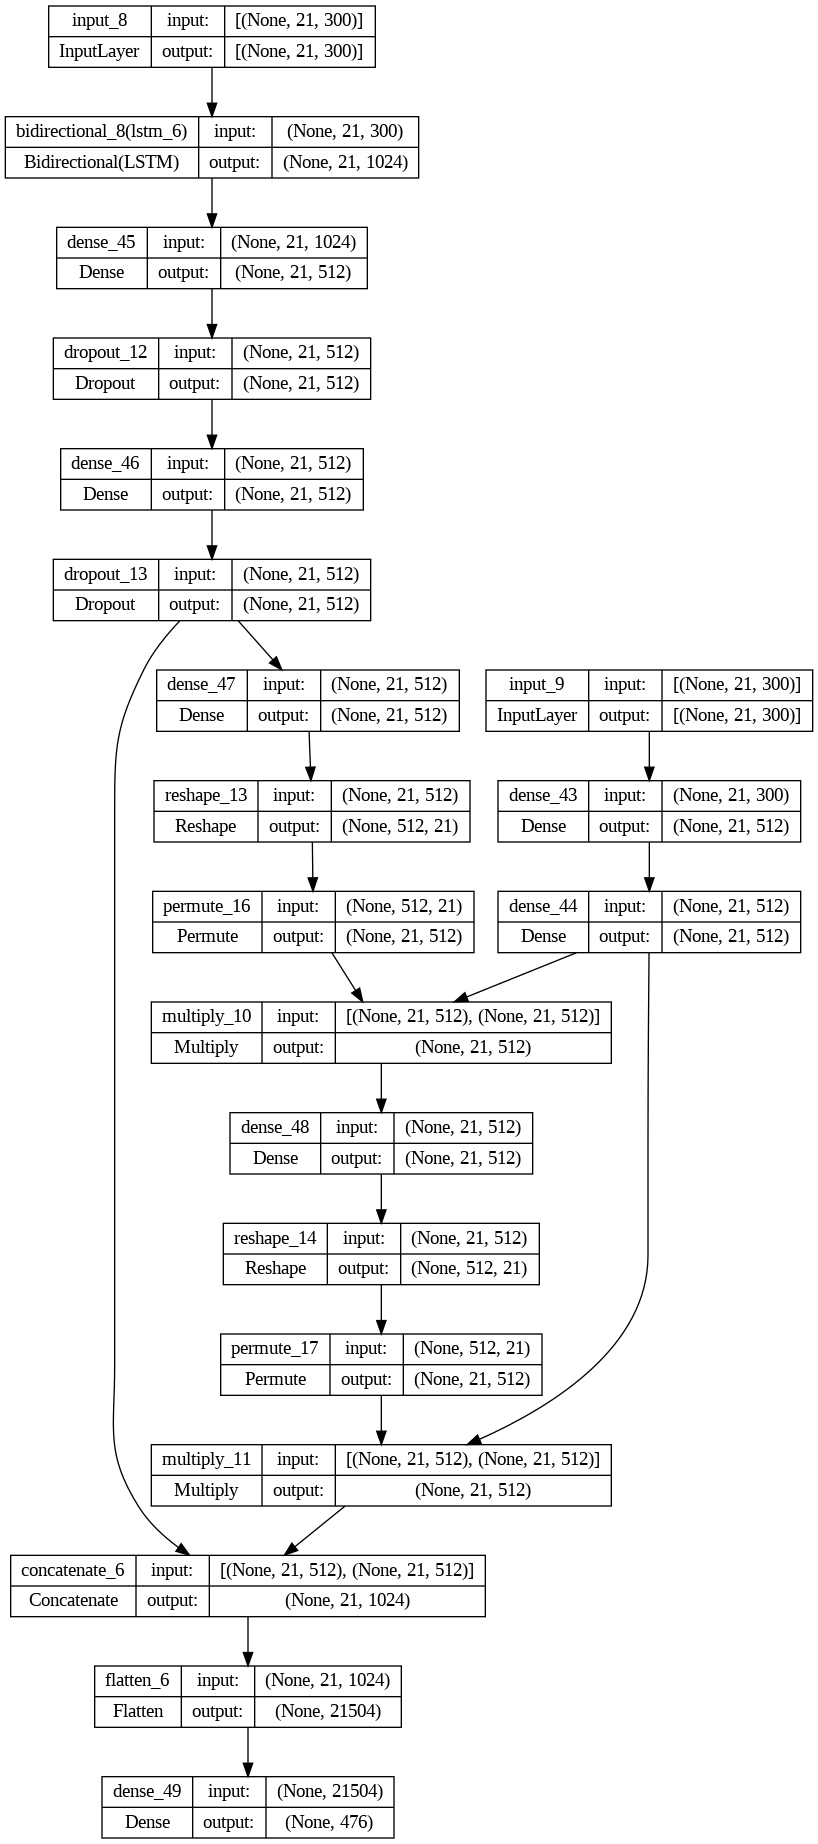

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot_3.png', show_shapes=True, show_layer_names=True)

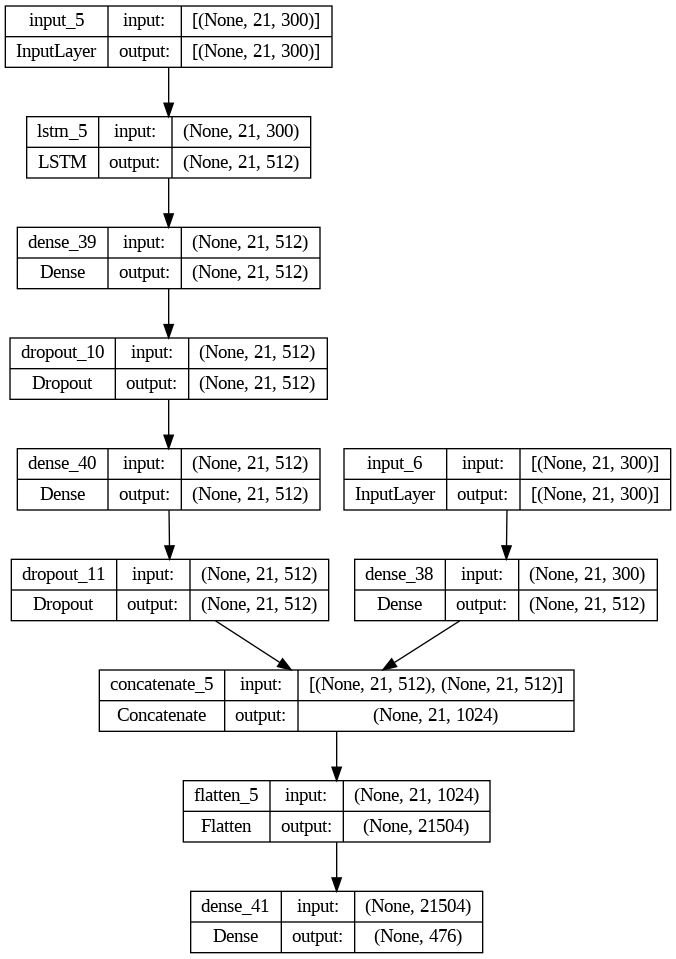

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:

model.save('my_model_2.h5')  # Save the model


In [ ]:
model = Model([ques,images],[out])

In [ ]:
model_config = model.get_config()

# Convert model information to JSON
model_json = json.dumps(model_config)

# Save JSON to a file
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
!pip install keras-visualizer

In [ ]:
from keras_visualizer import visualizer
visualizer(model, file_name='graph_2', file_format="png", view=True)

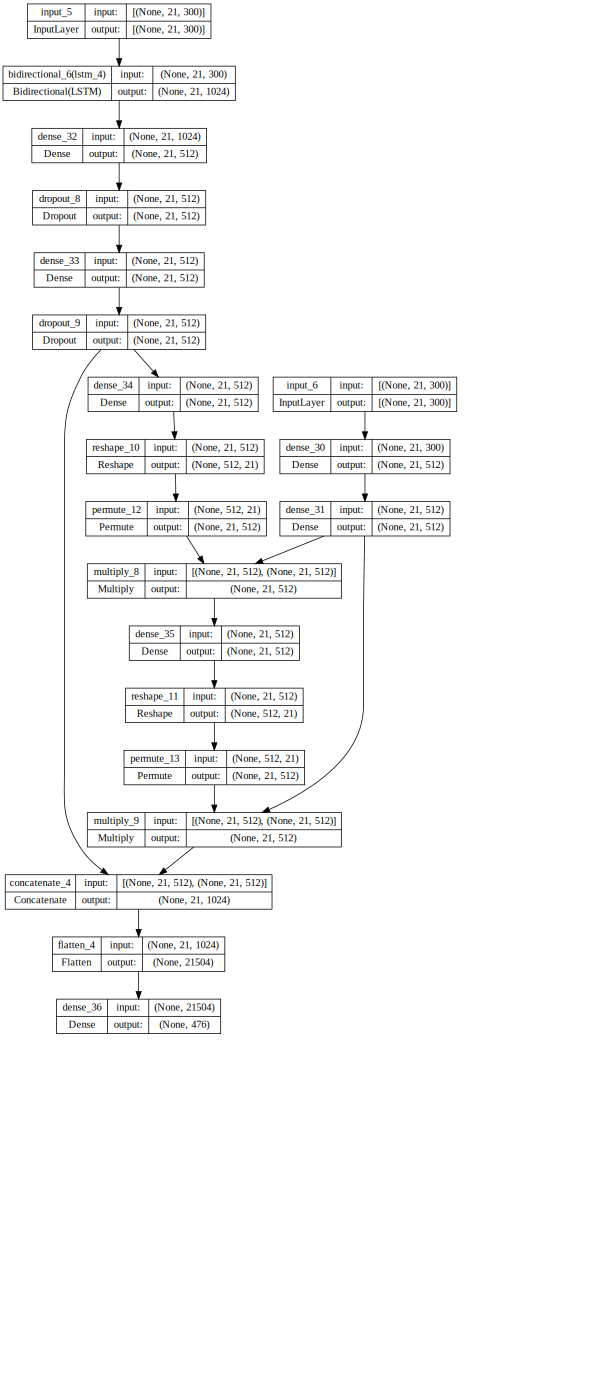

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Render the dot graph to an SVG image
SVG(dot.create(prog='dot', format='svg'))

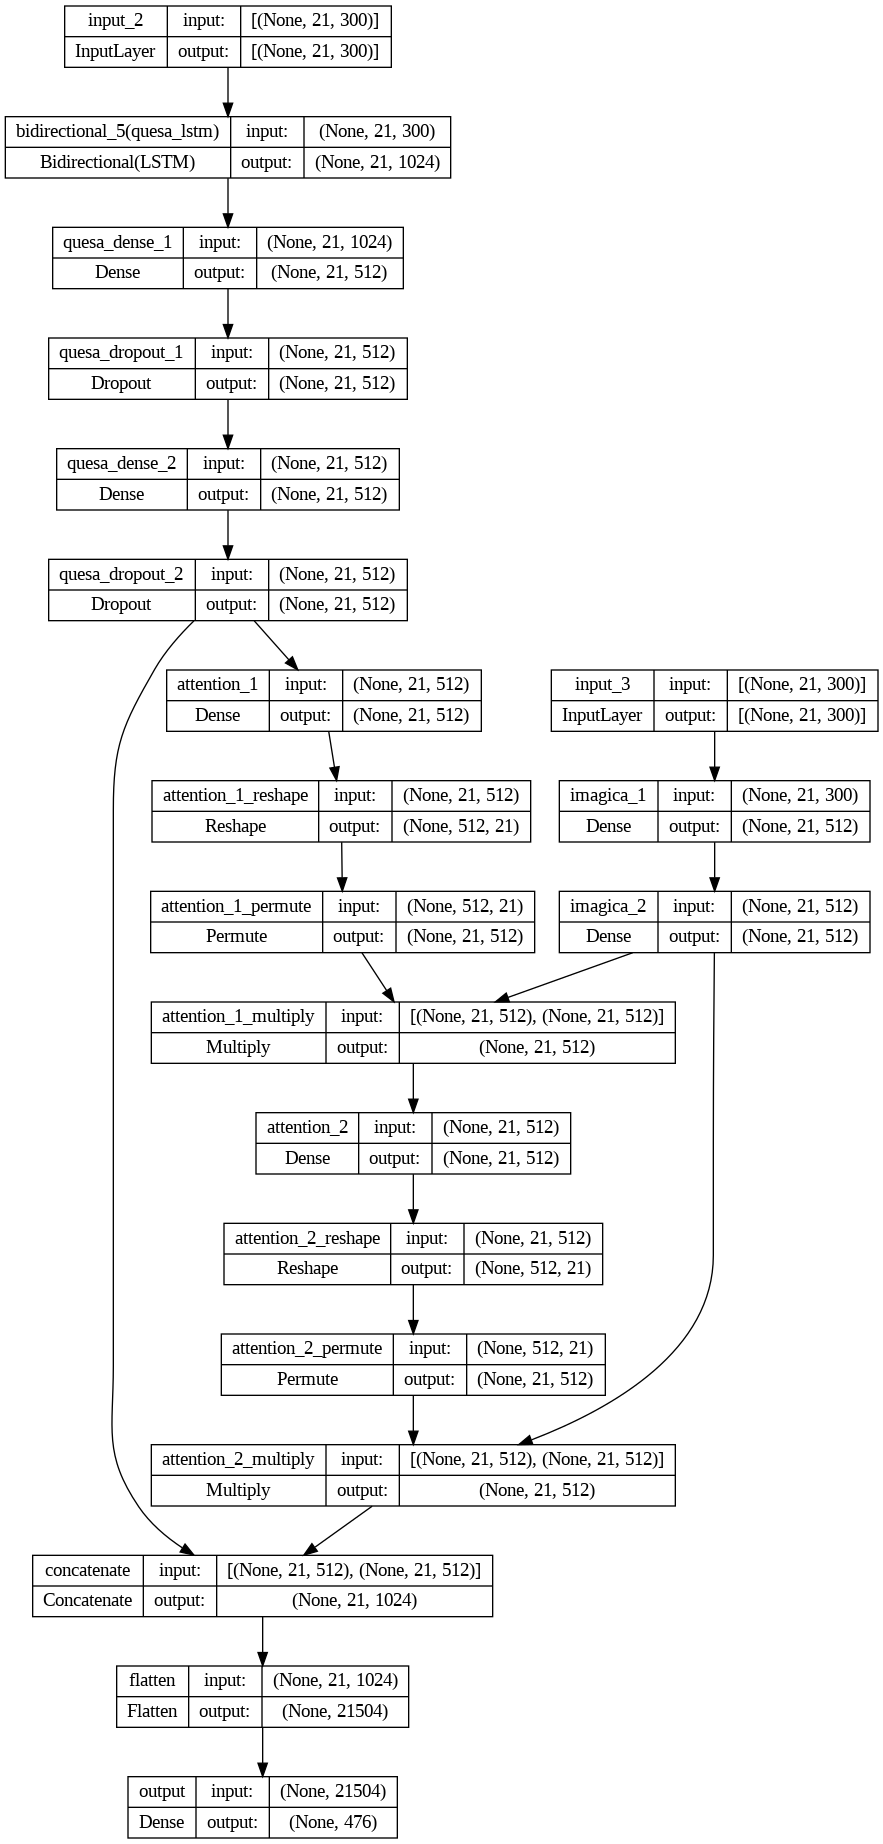

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

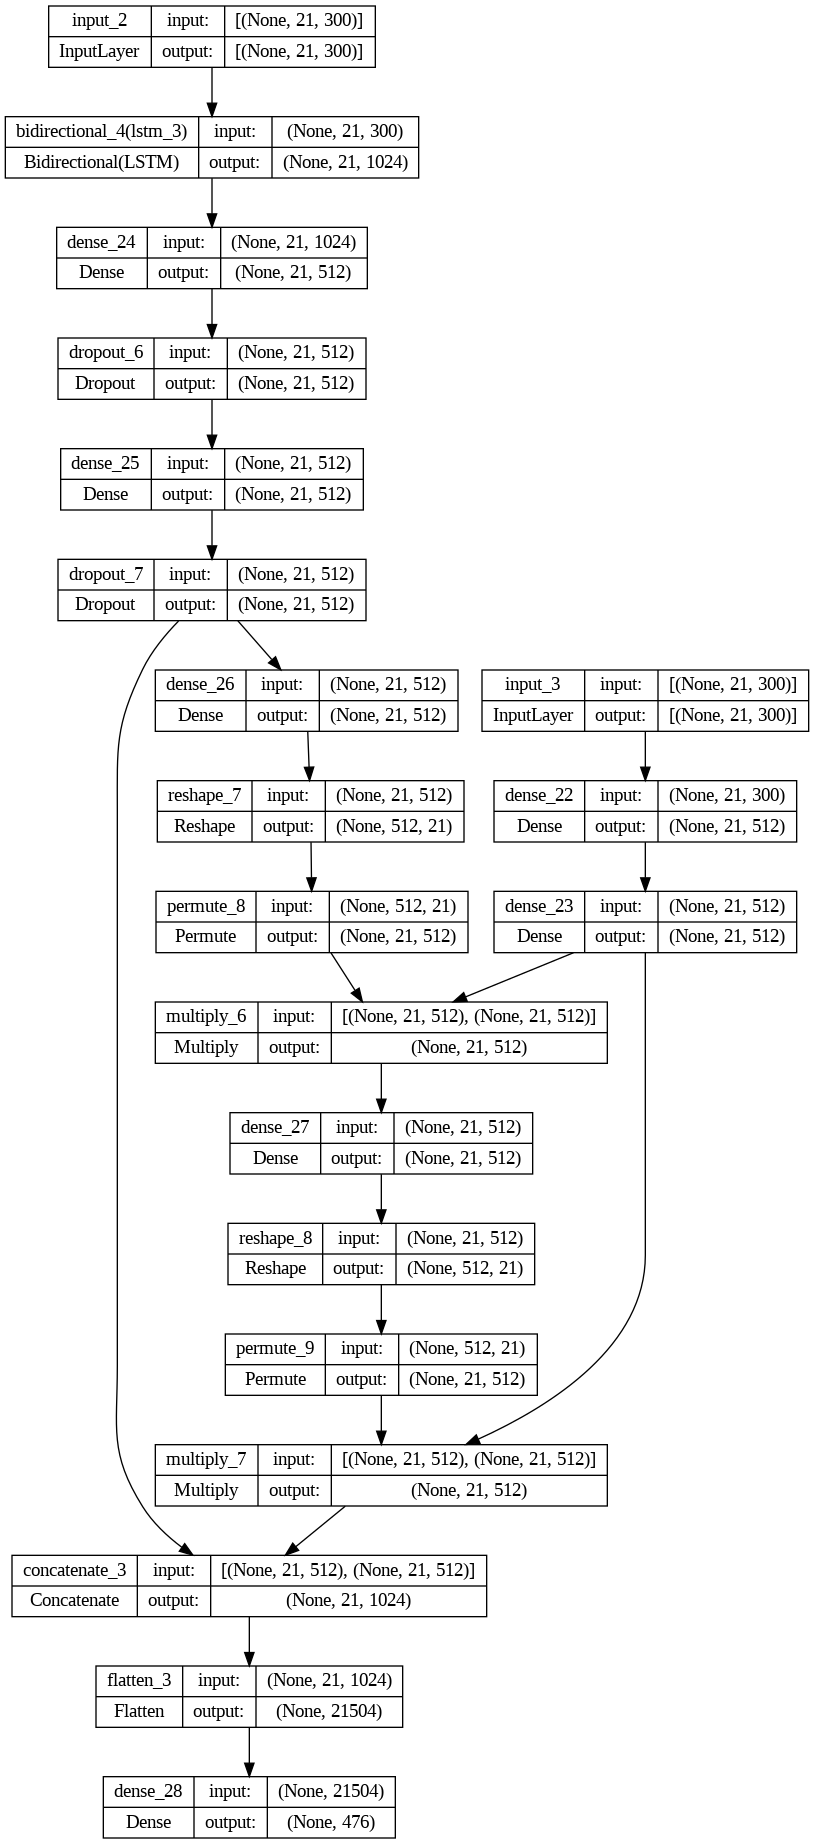

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

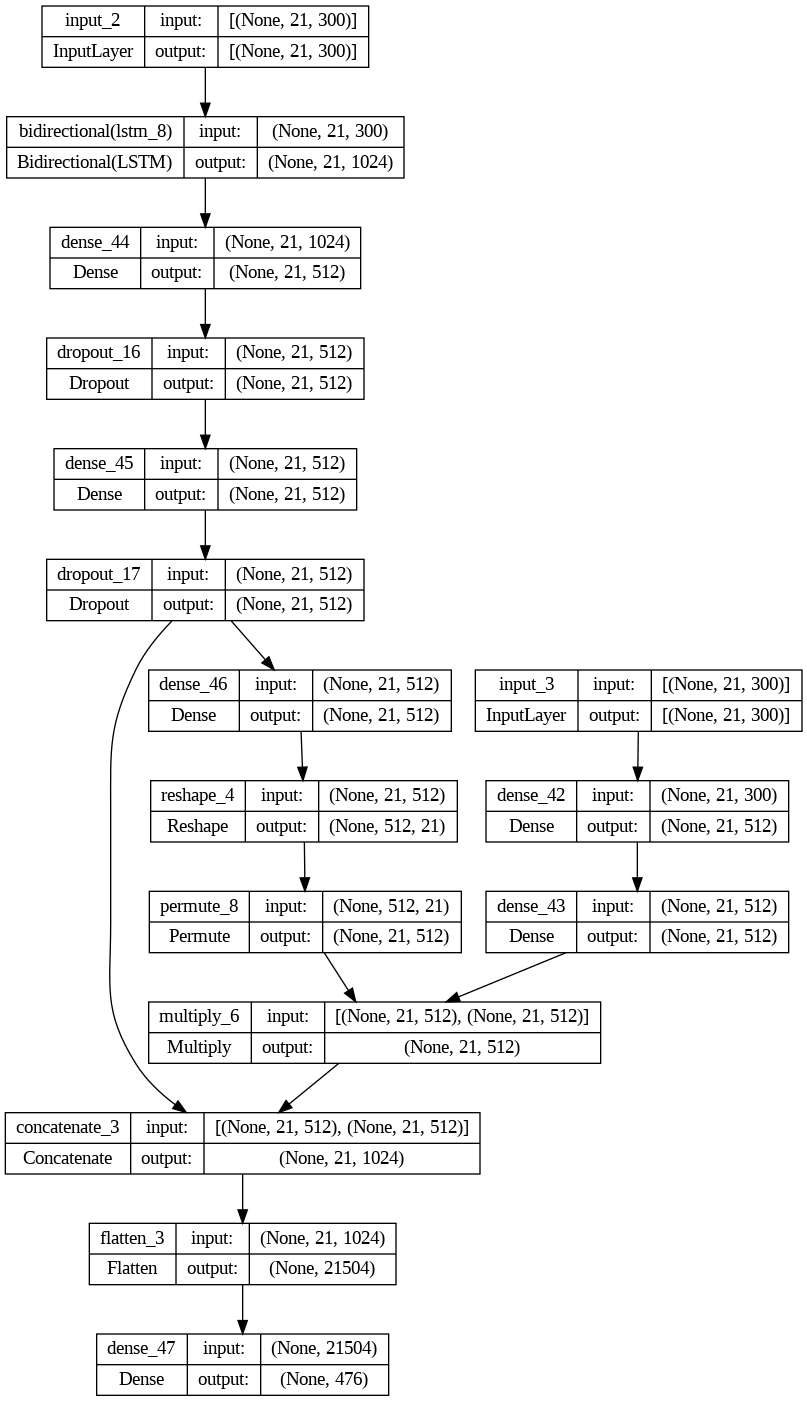

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

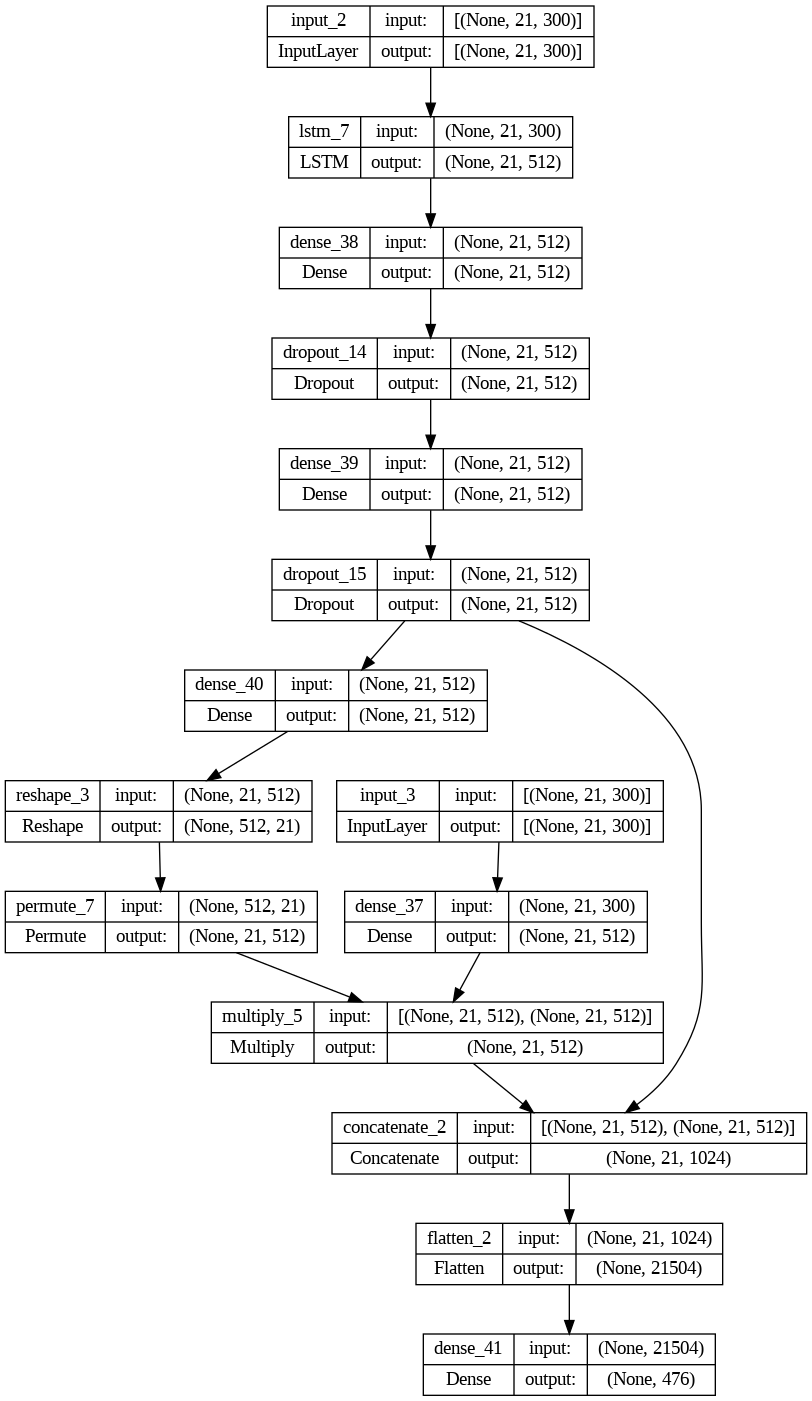

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

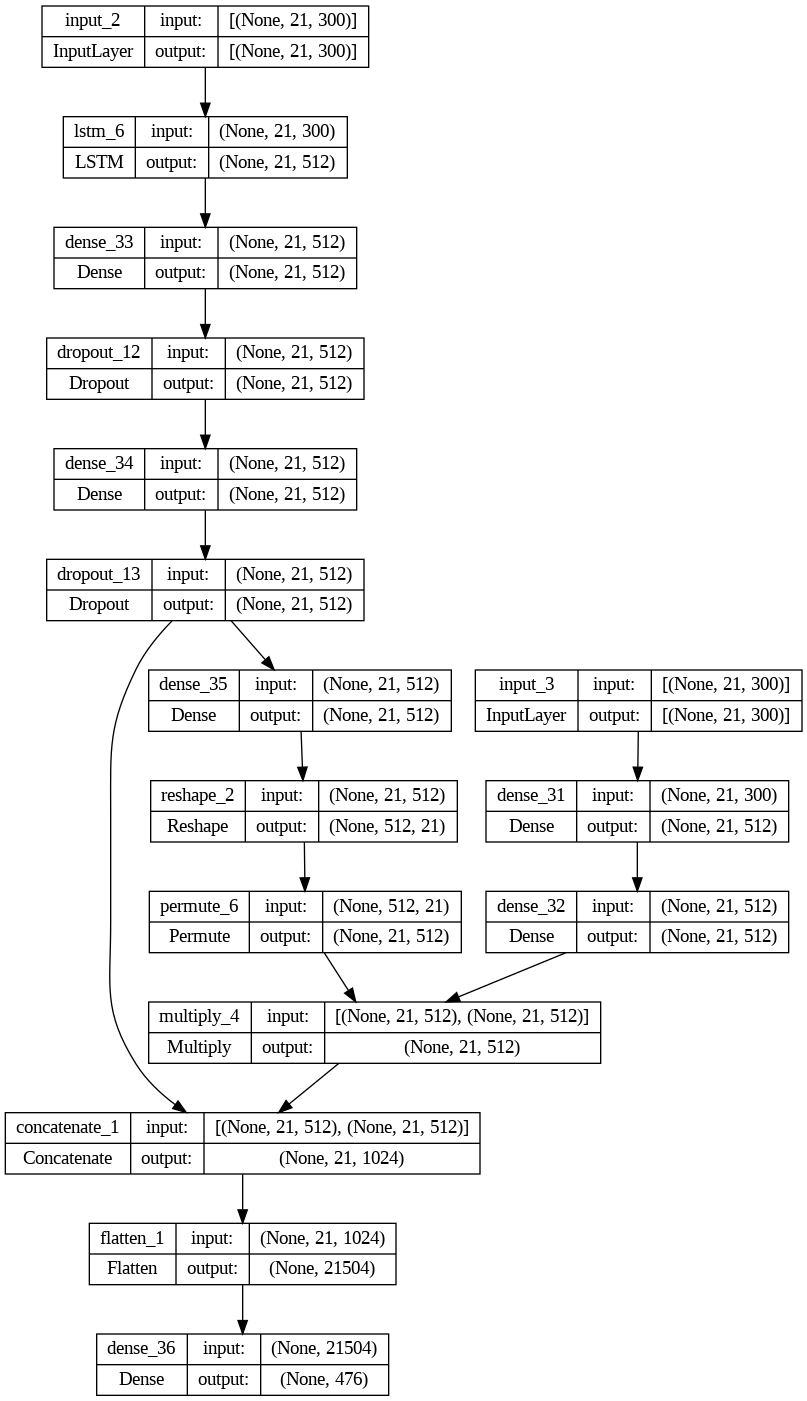

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

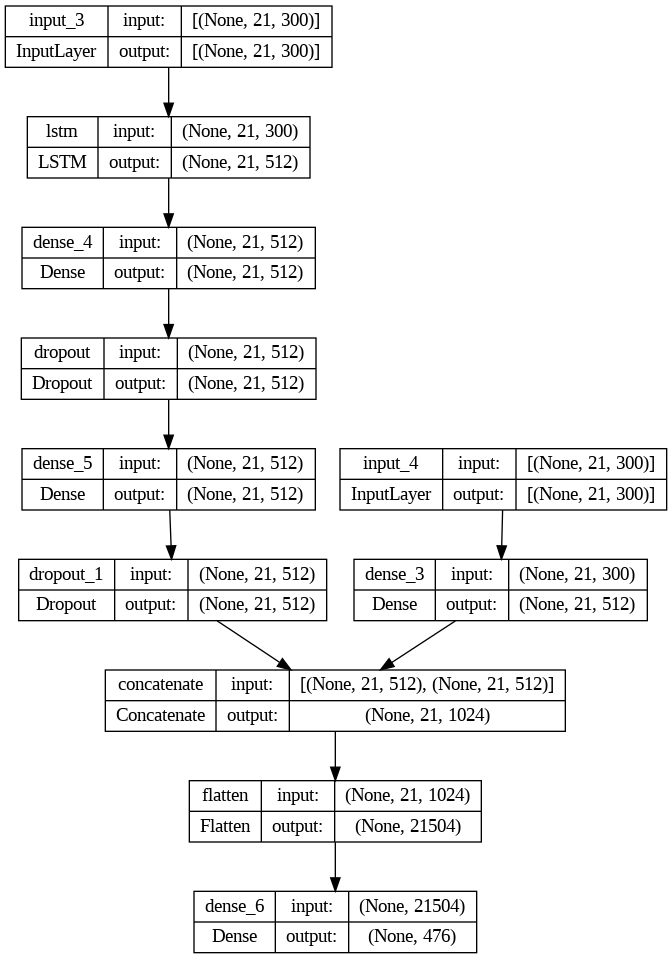

In [ ]:
from tensorflow.keras.utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
answers = tf.keras.utils.to_categorical(ans)
answers.shape

(2300, 475)

In [ ]:
answers = tf.keras.utils.to_categorical(ans)
answers.shape

(2300, 475)

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 300)]            0         []                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 21, 1024)             3330048   ['input_2[0][0]']             
 onal)                                                                                            
                                                                                                  
 quesa_dense_1 (Dense)       (None, 21, 512)              524800    ['bidirectional_5[0][0]']     
                                                                                                  
 quesa_dropout_1 (Dropout)   (None, 21, 512)              0         ['quesa_dense_1[0][0]'] 

In [ ]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 21, 300)]            0         []                            
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 21, 1024)             3330048   ['input_8[0][0]']             
 onal)                                                                                            
                                                                                                  
 dense_45 (Dense)            (None, 21, 512)              524800    ['bidirectional_8[0][0]']     
                                                                                                  
 dropout_12 (Dropout)        (None, 21, 512)              0         ['dense_45[0][0]']     

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 300)]            0         []                            
                                                                                                  
 lstm_7 (LSTM)               (None, 21, 512)              1665024   ['input_2[0][0]']             
                                                                                                  
 dense_38 (Dense)            (None, 21, 512)              262656    ['lstm_7[0][0]']              
                                                                                                  
 dropout_14 (Dropout)        (None, 21, 512)              0         ['dense_38[0][0]']            
                                                                                            

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 300)]            0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 21, 512)              1665024   ['input_2[0][0]']             
                                                                                                  
 dense_33 (Dense)            (None, 21, 512)              262656    ['lstm_6[0][0]']              
                                                                                                  
 dropout_12 (Dropout)        (None, 21, 512)              0         ['dense_33[0][0]']            
                                                                                            

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 300)]            0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 21, 1024)             3330048   ['input_2[0][0]']             
 al)                                                                                              
                                                                                                  
 dense_3 (Dense)             (None, 21, 512)              524800    ['bidirectional[0][0]']       
                                                                                                  
 dropout (Dropout)           (None, 21, 512)              0         ['dense_3[0][0]']       

Epoch 1/50
72/72 [==============================] - 6s 18ms/step - loss: 3.7214 - accuracy: 0.2722
Epoch 2/50
72/72 [==============================] - 1s 17ms/step - loss: 3.0183 - accuracy: 0.3535
Epoch 3/50
72/72 [==============================] - 1s 17ms/step - loss: 2.4128 - accuracy: 0.4161
Epoch 4/50
72/72 [==============================] - 1s 17ms/step - loss: 1.7913 - accuracy: 0.5322
Epoch 5/50
72/72 [==============================] - 1s 17ms/step - loss: 1.2729 - accuracy: 0.6400
Epoch 6/50
72/72 [==============================] - 1s 17ms/step - loss: 0.9258 - accuracy: 0.7257
Epoch 7/50
72/72 [==============================] - 1s 17ms/step - loss: 0.6924 - accuracy: 0.7822
Epoch 8/50
72/72 [==============================] - 1s 17ms/step - loss: 0.5302 - accuracy: 0.8243
Epoch 9/50
72/72 [==============================] - 1s 17ms/step - loss: 0.4699 - accuracy: 0.8465
Epoch 10/50
72/72 [==============================] - 1s 17ms/step - loss: 0.4103 - accuracy: 0.8691
Epoch 11/

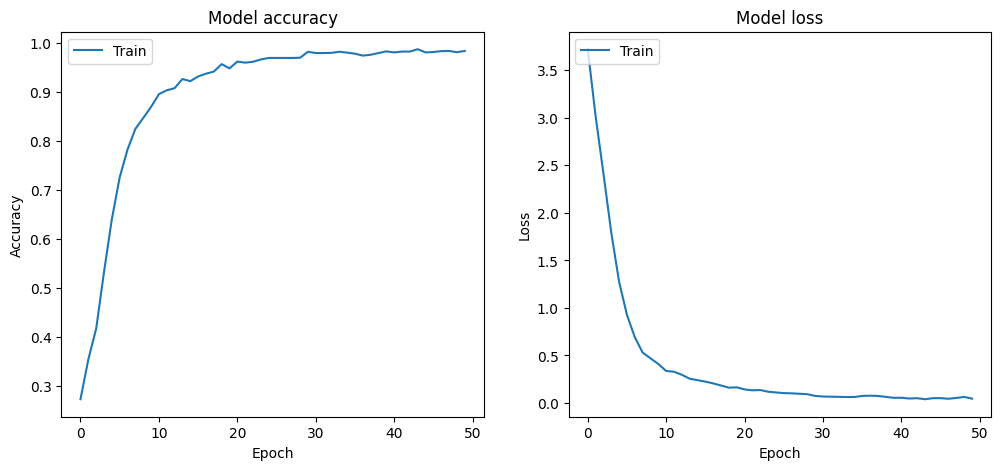

In [ ]:
history = model.fit([que, img], ans, epochs=50, batch_size=32, verbose=1)

# Plotting
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

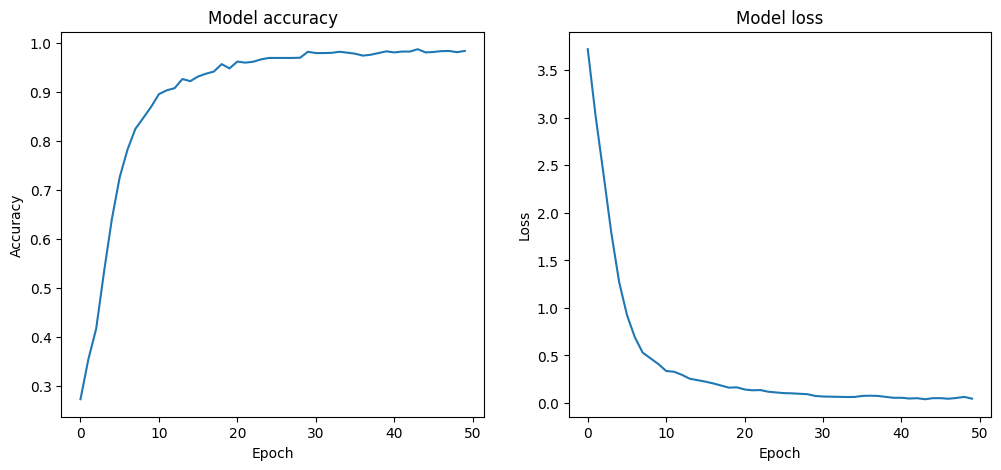

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


# Save the figure
plt.savefig('model_performance.png', bbox_inches='tight')

plt.show()

In [ ]:
model.fit([que, img],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 7s 18ms/step - loss: 4.0681 - accuracy: 0.2774
Epoch 2/50
72/72 [==============================] - 1s 17ms/step - loss: 3.0621 - accuracy: 0.3204
Epoch 3/50
72/72 [==============================] - 1s 17ms/step - loss: 2.4733 - accuracy: 0.3987
Epoch 4/50
72/72 [==============================] - 1s 17ms/step - loss: 1.8371 - accuracy: 0.5196
Epoch 5/50
72/72 [==============================] - 1s 17ms/step - loss: 1.3201 - accuracy: 0.6200
Epoch 6/50
72/72 [==============================] - 1s 17ms/step - loss: 0.9686 - accuracy: 0.6983
Epoch 7/50
72/72 [==============================] - 1s 17ms/step - loss: 0.7356 - accuracy: 0.7626
Epoch 8/50
72/72 [==============================] - 1s 17ms/step - loss: 0.5875 - accuracy: 0.8013
Epoch 9/50
72/72 [==============================] - 1s 17ms/step - loss: 0.4778 - accuracy: 0.8491
Epoch 10/50
72/72 [==============================] - 1s 17ms/step - loss: 0.4008 - accuracy: 0.8635
Epoch 11/

In [ ]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 7s 19ms/step - loss: 4.2062 - accuracy: 0.2935
Epoch 2/50
72/72 [==============================] - 1s 17ms/step - loss: 3.4661 - accuracy: 0.3383
Epoch 3/50
72/72 [==============================] - 1s 17ms/step - loss: 2.8635 - accuracy: 0.3587
Epoch 4/50
72/72 [==============================] - 1s 17ms/step - loss: 1.9844 - accuracy: 0.4457
Epoch 5/50
72/72 [==============================] - 1s 17ms/step - loss: 1.4885 - accuracy: 0.5235
Epoch 6/50
72/72 [==============================] - 1s 17ms/step - loss: 1.2676 - accuracy: 0.5674
Epoch 7/50
72/72 [==============================] - 1s 17ms/step - loss: 1.0825 - accuracy: 0.6035
Epoch 8/50
72/72 [==============================] - 1s 17ms/step - loss: 0.9539 - accuracy: 0.6439
Epoch 9/50
72/72 [==============================] - 1s 17ms/step - loss: 0.8532 - accuracy: 0.6665
Epoch 10/50
72/72 [==============================] - 1s 17ms/step - loss: 0.7565 - accuracy: 0.7030
Epoch 11/

In [ ]:
model.fit([img,que],ans,epochs = 100,batch_size=32,verbose=1)

Epoch 1/100
72/72 [==============================] - 1s 13ms/step - loss: 0.1358 - accuracy: 0.9596
Epoch 2/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1343 - accuracy: 0.9591
Epoch 3/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1355 - accuracy: 0.9591
Epoch 4/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1339 - accuracy: 0.9570
Epoch 5/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1254 - accuracy: 0.9617
Epoch 6/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1226 - accuracy: 0.9613
Epoch 7/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1174 - accuracy: 0.9700
Epoch 8/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1173 - accuracy: 0.9643
Epoch 9/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1101 - accuracy: 0.9670
Epoch 10/100
72/72 [==============================] - 1s 12ms/step - loss: 0.1166 - accuracy: 0.9622

In [ ]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 7s 13ms/step - loss: 4.2438 - accuracy: 0.2683
Epoch 2/50
72/72 [==============================] - 1s 12ms/step - loss: 3.6185 - accuracy: 0.3248
Epoch 3/50
72/72 [==============================] - 1s 12ms/step - loss: 3.0634 - accuracy: 0.3457
Epoch 4/50
72/72 [==============================] - 1s 12ms/step - loss: 2.1149 - accuracy: 0.4317
Epoch 5/50
72/72 [==============================] - 1s 12ms/step - loss: 1.4161 - accuracy: 0.5604
Epoch 6/50
72/72 [==============================] - 1s 12ms/step - loss: 1.1359 - accuracy: 0.6039
Epoch 7/50
72/72 [==============================] - 1s 12ms/step - loss: 0.9918 - accuracy: 0.6452
Epoch 8/50
72/72 [==============================] - 1s 12ms/step - loss: 0.8864 - accuracy: 0.6609
Epoch 9/50
72/72 [==============================] - 1s 12ms/step - loss: 0.8162 - accuracy: 0.6922
Epoch 10/50
72/72 [==============================] - 1s 13ms/step - loss: 0.7634 - accuracy: 0.7043
Epoch 11/

In [ ]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 6s 12ms/step - loss: 3.4507 - accuracy: 0.3483
Epoch 2/50
72/72 [==============================] - 1s 10ms/step - loss: 1.6650 - accuracy: 0.5626
Epoch 3/50
72/72 [==============================] - 1s 10ms/step - loss: 0.6447 - accuracy: 0.7883
Epoch 4/50
72/72 [==============================] - 1s 10ms/step - loss: 0.3546 - accuracy: 0.8748
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2667 - accuracy: 0.9030
Epoch 6/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2399 - accuracy: 0.9157
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2076 - accuracy: 0.9343
Epoch 8/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1765 - accuracy: 0.9461
Epoch 9/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1601 - accuracy: 0.9522
Epoch 10/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1352 - accuracy: 0.9604
Epoch 11/

In [ ]:
model.fit([img,que],ans,epochs = 30,batch_size=32,verbose=1)

Epoch 1/30
72/72 [==============================] - 5s 11ms/step - loss: 3.5497 - accuracy: 0.3261
Epoch 2/30
72/72 [==============================] - 1s 10ms/step - loss: 1.6122 - accuracy: 0.5835
Epoch 3/30
72/72 [==============================] - 1s 10ms/step - loss: 0.5931 - accuracy: 0.8161
Epoch 4/30
72/72 [==============================] - 1s 10ms/step - loss: 0.3348 - accuracy: 0.8835
Epoch 5/30
72/72 [==============================] - 1s 10ms/step - loss: 0.2380 - accuracy: 0.9226
Epoch 6/30
72/72 [==============================] - 1s 10ms/step - loss: 0.1947 - accuracy: 0.9383
Epoch 7/30
72/72 [==============================] - 1s 10ms/step - loss: 0.1549 - accuracy: 0.9539
Epoch 8/30
72/72 [==============================] - 1s 10ms/step - loss: 0.1367 - accuracy: 0.9570
Epoch 9/30
72/72 [==============================] - 1s 11ms/step - loss: 0.1196 - accuracy: 0.9652
Epoch 10/30
72/72 [==============================] - 1s 11ms/step - loss: 0.1173 - accuracy: 0.9639
Epoch 11/

In [ ]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 3s 12ms/step - loss: 10.4432 - accuracy: 0.2943
Epoch 2/50
72/72 [==============================] - 1s 11ms/step - loss: 2.1402 - accuracy: 0.6094
Epoch 3/50
72/72 [==============================] - 1s 11ms/step - loss: 2.9801 - accuracy: 0.6277
Epoch 4/50
72/72 [==============================] - 1s 11ms/step - loss: 3.3520 - accuracy: 0.6549
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 3.8808 - accuracy: 0.6729
Epoch 6/50
72/72 [==============================] - 1s 11ms/step - loss: 3.9790 - accuracy: 0.7060
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 4.7241 - accuracy: 0.7324
Epoch 8/50
72/72 [==============================] - 1s 11ms/step - loss: 3.8976 - accuracy: 0.7389
Epoch 9/50
72/72 [==============================] - 1s 11ms/step - loss: 4.6822 - accuracy: 0.7731
Epoch 10/50
72/72 [==============================] - 1s 11ms/step - loss: 4.4351 - accuracy: 0.7760
Epoch 11

In [ ]:
model.save('/content/drive/MyDrive/VQA_Model_5')

In [ ]:
# Define a separate model for extracting attention weights
model_for_visualization = Model(inputs=[ques,images], outputs=[out, attention_1, attention_2])

In [ ]:
# Making predictions and getting attention weights
predictions, attention_weights_1, attention_weights_2 = model_for_visualization.predict([que, img])

72/72 [==============================] - 1s 8ms/step


In [ ]:
que.shape

TensorShape([2300, 21, 300])

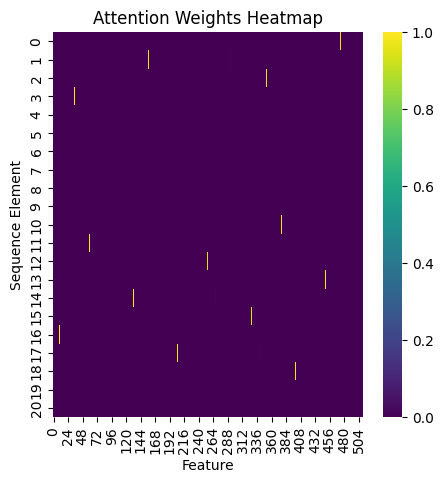

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_1[0]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


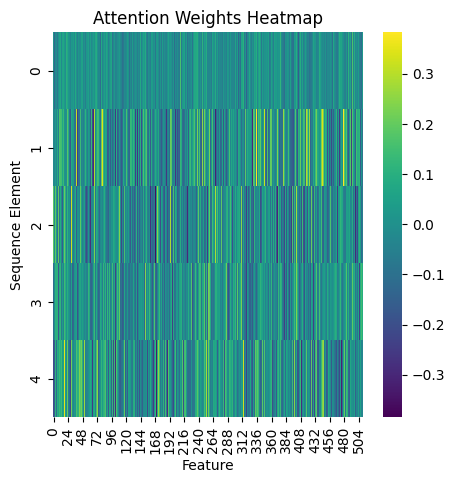

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = img_wt_1[0][:5]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


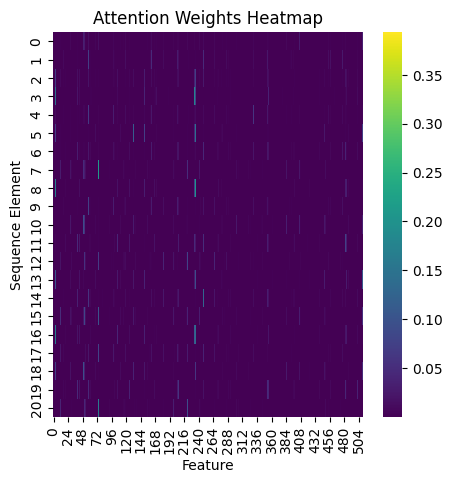

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_2[0]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


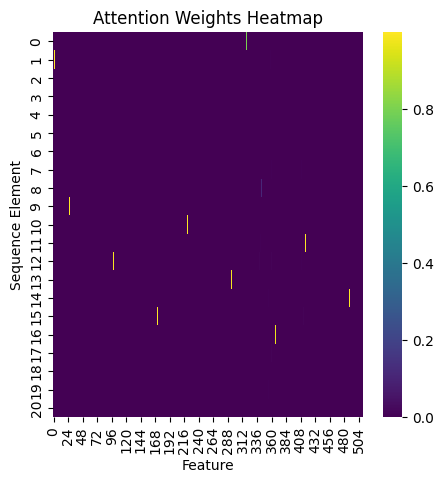

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_1[0]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


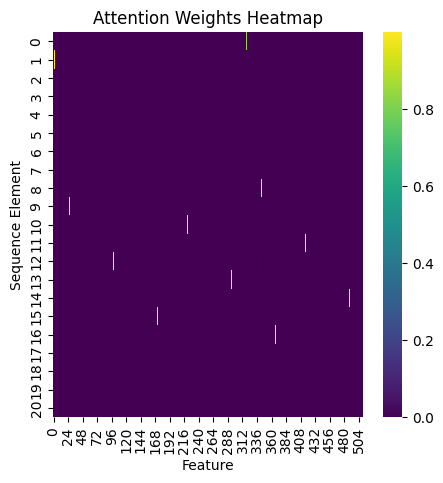

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_1[2]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


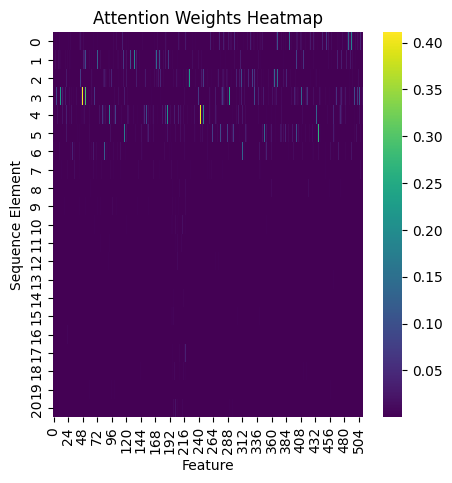

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_2[0]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


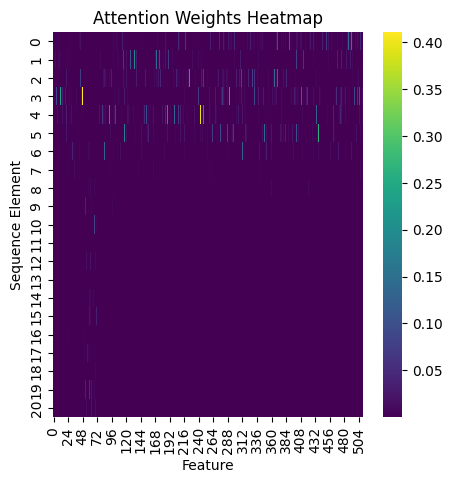

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# attention_weights_1[0] is the attention for the first example in your batch
attention_data = attention_weights_2[2]

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(attention_data, annot=False, cmap='viridis')
plt.xlabel('Feature')
plt.ylabel('Sequence Element')
plt.title('Attention Weights Heatmap')
plt.show()


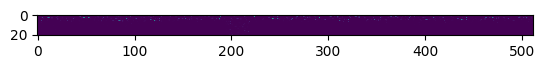

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example for visualizing attention on an image
# Normalize the attention weights to [0, 1]
attention_weights_normalized = attention_weights_2[0] / np.max(attention_weights_2[0])

# Assuming 'sample_image' is the image you want to visualize
plt.imshow(attention_weights_normalized)
plt.show()

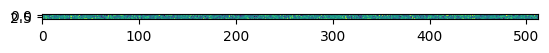

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example for visualizing attention on an image
# Normalize the attention weights to [0, 1]
attention_weights_normalized = img_wt_1[0] / np.max(img_wt_1[0])

# Assuming 'sample_image' is the image you want to visualize

plt.imshow(attention_weights_normalized[:5])
plt.show()

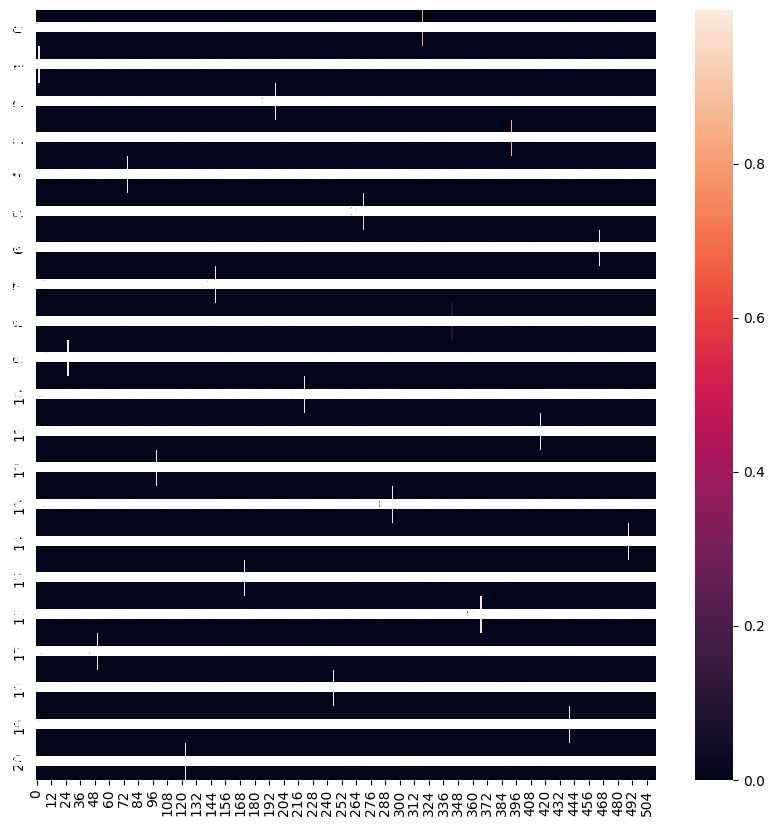

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming attention_weights_1 is related to words in a question
# and you have a list of words in 'words_list'

# Plotting the first set of attention weights for the first example
plt.figure(figsize=(10, 10))
sns.heatmap(attention_weights_1[0], annot=True)
plt.show()

In [ ]:
prediction, attention_weights_1, attention_weights_2 = model.predict([img,que])

In [ ]:
prediction_confidence = model.predict([que,img])

72/72 [==============================] - 1s 8ms/step


In [ ]:
prediction_confidence[0][prediction[0]]

0.99952006

In [ ]:
prediction = tf.argmax(model.predict([que,img]),axis=1).numpy()

72/72 [==============================] - 1s 8ms/step


In [ ]:
prediction[0]

1

In [ ]:
import json
x = open('/content/drive/MyDrive/trainset.json','r')
train = json.load(x)
train[0]

{'qid': 1,
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'answer': 'Yes',
 'answer_type': 'CLOSED',
 'question_type': 'PRES',
 'question': 'Are regions of the brain infarcted?',
 'phrase_type': 'freeform'}

In [ ]:
predictions.shape

(2300, 476)

## END OF THE NOTEBOOK :)